# Plusvalía Inmobiliaria en Chile: Un Estudio de Factores Urbanos.

# 1. Contexto y Motivación:

El mercado inmobiliario en Chile es dinámico y de gran interés tanto para inversionistas como para residentes. Uno de los factores clave al evaluar una propiedad es su potencial de plusvalía, es decir, el aumento de su valor en el tiempo. Sin embargo, predecir esta plusvalía es complejo, ya que depende de múltiples factores intrínsecos a la propiedad y, crucialmente, de su entorno urbano. 

El objetivo principal de este proyecto es identificar y cuantificar los factores del entorno urbano que tienen una mayor influencia en el valor (y potencial plusvalía) de las propiedades residenciales en algunas comunas de Chile.  Entender estos factores permitirá desarrollar un modelo que pueda, eventualmente, predecir el potencial de valorización de una propiedad basado en sus características y ubicación.

La audiencia objetivo para este análisis incluye a potenciales compradores de vivienda, inversionistas inmobiliarios, desarrolladores y planificadores urbanos, quienes podrían utilizar estos resultados para tomar decisiones más informadas sobre inversión, desarrollo y políticas urbanas. La motivación surge de la necesidad de herramientas basadas en datos para navegar un mercado complejo y tomar decisiones financieras significativas, como la compra de una vivienda.

# 2. Preguntas Objetivo:

¿Cómo influye la proximidad a diferentes categorías de POIs (educación, salud, comercio básico/retail, recreación verde/deporte) en el valor de las propiedades? ¿Existen categorías de POIs con mayor impacto que otras?

¿La predominancia de ciertos tipos de uso de suelo (residencial, comercial, industrial, áreas verdes) en el entorno cercano a una propiedad afecta su valor? ¿Las zonas industriales tienen un impacto negativo medible?

¿La cercanía a paradas de transporte público (datos GTFS) se correlaciona positivamente con el valor de las propiedades? ¿Hay diferencias entre tipos de paradas (ej. Metro vs. Micro)?

¿Cómo interactúan los factores del entorno con las características intrínsecas de las propiedades (ej. superficie, número de habitaciones, antigüedad) para determinar el precio?

¿En qué medida un modelo basado en estos factores del entorno puede predecir el valor actual de una propiedad o su potencial de plusvalía?

# 3. Datos:

# Fuente 1: Portal Inmobiliario (Web Scraping): #

Origen: Datos de listados inmobiliarios (venta/arriendo) recolectados mediante web scraping del sitio Portal Inmobiliario, almacenados originalmente en archivos SQLite.

Contenido: La información se organiza en tablas, siendo principal la más relevante (identificador mlc, precio, tipo, superficie, dormitorios, baños, dirección). Tablas adicionales (full_specs, full_specs_bin) detallan otras características.

Recolección - Preparación: Se cargaron los datos a pandas DataFrames y se aplicó un filtrado riguroso (detallado en filtrado_arriendo.ipynb y filtrado_venta.ipynb) para eliminar datos incompletos, inconsistentes, outliers, listados no residenciales y corregir precios promocionales en arriendos. Los próximos pasos incluyen la geocodificación de direcciones para obtener coordenadas, la conversión a GeoDataFrame (geopandas) y la unificación del CRS con las otras fuentes.

# Fuente 2: OpenStreetMap (OSM) vía Geofabrik: #

Origen: Descarga de Shapefiles gratuitos para Chile desde Geofabrik.

Contenido:

gis_osm_pois_free_1.shp: Puntos de Interés (POIs) con geometría de punto y categorización (fclass). Variables clave: osm_id, fclass, name, geometry.

gis_osm_landuse_a_free_1.shp: Polígonos de Uso de Suelo con categorización (fclass). Variables clave: osm_id, fclass, name, geometry.

Recolección - Preparación: Los archivos .shp se cargan usando geopandas. Se realiza limpieza (eliminar nulos en fclass, geometrías inválidas) y se categorizan los fclass según relevancia (educación, salud, comercio, recreación, zonas verdes, etc.) en GeoDataFrames separados, como se muestra en el notebook pois.ipynb.

# Fuente 3: GTFS - Directorio de Transporte Público Metropolitano: #

Origen: Archivos de texto en formato GTFS descargados de la plataforma oficial.

Contenido: Específicamente el archivo stops.txt, que contiene la ubicación (latitud, longitud) de las paradas de transporte público. Variables clave: stop_id, stop_name, stop_lat, stop_lon.

Recolección - Preparación: El archivo stops.txt se carga con pandas. Se limpia (eliminar nulos en coordenadas) y se convierte en un GeoDataFrame usando geopandas.points_from_xy, asignando un CRS. El proceso se detalla en el notebook paradas.ipynb. Se unificará el CRS con los datos de OSM. 

# 4. Análisis

In [1]:
# Imports
import pandas as pd
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import os

In [2]:
ruta_stops = os.path.join("DB", "Conectividad y POIs", "Paradas", "GTFS", "stops.txt")
df_stops = pd.read_csv(ruta_stops)

In [3]:
df_rail = df_stops[
    df_stops["stop_url"].str.contains("https://www.metro.cl/estacion/", na=False)
    | df_stops["stop_code"].str.startswith("MT-", na=False)
    | (df_stops["stop_name"].str.startswith("Estación ", na=False) &
       df_stops["stop_name"].str.endswith(" (Anden1)", na=False))
]

In [4]:
db_path = os.path.join("DB", "database_arriendo_clean.db")
tablas_nombres = ('principal', 'full_specs', 'full_specs_bin', 'grupos_bin')

conn = sql.connect(db_path)
df_arr, _, _, _ = [pd.read_sql_query(f"SELECT * FROM {tab}", conn) for tab in tablas_nombres]
conn.close()

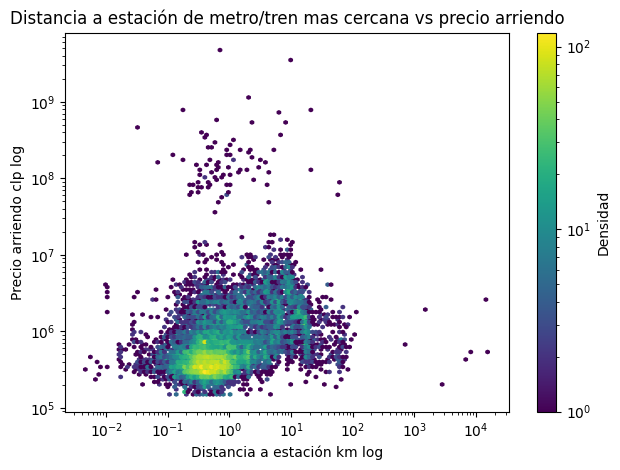

In [5]:
R = 6371.0088
a = df_arr.dropna(subset=['lat','lon']).copy()
r = df_rail.dropna(subset=['stop_lat','stop_lon']).copy()

a['dist_km']=BallTree(np.deg2rad(r[['stop_lat','stop_lon']])).query(np.deg2rad(a[['lat','lon']]),k=1)[0].ravel()*R
a['precio']=pd.to_numeric(a['$'],errors='coerce')
g=a.dropna(subset=['dist_km','precio'])
plt.hexbin(g['dist_km'],g['precio'],gridsize=120,bins='log' ,xscale='log',yscale='log')
plt.xlabel('Distancia a estación km log'); plt.ylabel('Precio arriendo clp log')
plt.colorbar(label='Densidad'); plt.title('Distancia a estación de metro/tren mas cercana vs precio arriendo')
plt.tight_layout(); plt.show()